In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tools.data_loading import get_lincs
from tools.metrics import *
from tools.utils import *

# Data Loading

In [3]:
lincs, lincs_genes, cell_lines = get_lincs()

Pulling folder parsed/literature_datasets/L1000
Pulling folder parsed/proteins


In [4]:
lincs.shape # num KOs X num transcripts X num cell lines

(5002, 978, 9)

## Z-score filter for DEGs

In [5]:
THRESH = 1.96
lincs[abs(lincs)<THRESH] = 0
lincs[abs(lincs)>THRESH] = 1

### Creating a Null
In order to compare the following experiments with something, within each cell line i'll create a random effect null model by shuffling the rows in each cell line (handling cell lines independently).

In [6]:
#firstly will make a null
lincs_shuffled = np.copy(lincs)
for cell_line in np.arange(lincs.shape[-1]):
    order = np.arange(lincs.shape[0])
    np.random.shuffle(order)
    lincs_shuffled[:,:,cell_line] = lincs[order,:,cell_line] 

## Distance Calculations

In [7]:
metric = 'jaccard'
dists= {'real':primary_dists(lincs, metric = metric),
        'shuffled':primary_dists(lincs_shuffled, metric = metric)}

In [8]:
r2s = {'real':[], 'shuffled':[]}
idxs = np.triu_indices(dists['real'].shape[-1],1)
for cpair in comb(np.arange(dists['real'].shape[0]),2):
    for key in dists:
        r2s[key].append(np.corrcoef(dists[key][cpair[0],:,:][idxs], dists[key][cpair[1],:,:][idxs])[0,1])

[Text(1, 0, 'Real'), Text(2, 0, 'Shuffled')]

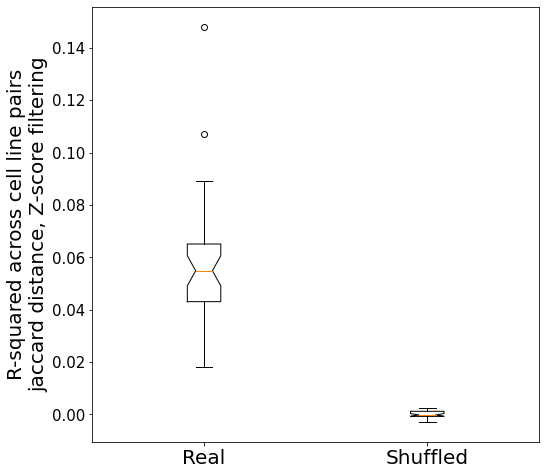

In [9]:
fig, ax = plt.subplots(1, figsize = (8,8))
ax.boxplot([r2s['real'],r2s['shuffled']], notch = True)
ax.set_ylabel(f"R-squared across cell line pairs\n{metric} distance, Z-score filtering",size = 20)
ax.tick_params(labelsize = 15)
ax.set_xticklabels(['Real','Shuffled'], size = 20)

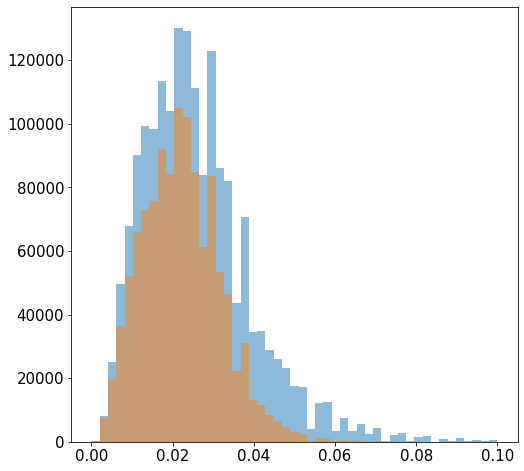

In [10]:
fig, ax = plt.subplots(1, figsize = (8,8))

med_dists = np.median(1-dists['real'], axis = 0)
indices = np.triu_indices(med_dists.shape[0], 1)
vals = med_dists[indices]
ax.hist(vals[vals!=0], bins = np.linspace(0,0.1,50),alpha = 0.5)

med_dists_shuffled = np.median(1-dists['shuffled'], axis = 0)
indices = np.triu_indices(med_dists_shuffled.shape[0], 1)
vals = med_dists_shuffled[indices]
ax.hist(vals[vals!=0], bins = np.linspace(0,0.1,50),alpha = 0.5)

ax.tick_params(labelsize = 15)


# Chi2 contigency test comparing genes

In [12]:
lincs, lincs_genes, cell_lines = get_lincs()
lincs[abs(lincs)<THRESH] = 0
lincs[lincs>THRESH] = 1
lincs[lincs<-THRESH] = -1

Pulling folder parsed/literature_datasets/L1000


In [ ]:
lincs_shuffled = np.copy(lincs)
for cell_line in np.arange(lincs.shape[-1]):
    order = np.arange(lincs.shape[0])
    np.random.shuffle(order)
    lincs_shuffled[:,:,cell_line] = lincs[order,:,cell_line] 

In [52]:
import statsmodels.api as sm
from scipy.stats import chi2_contingency as c2c
def chi2_distance(dat):
    table = sm.stats.Table.from_data(dat)
    return c2c(table.table_orig.values)[0]
    

In [ ]:
from itertools import combinations as comb
c2c_dists = np.zeros((lincs.shape[0],lincs.shape[0]))
for combo in comb(np.arange(lincs.shape[0]),2):
    pairdist = chi2_distance(lincs[combo,:,0].T)
    c2c_dists[combo[0],combo[1]] = pairdist
    c2c_dists[combo[1],combo[0]] = pairdist

In [10]:
import numpy as np
import matplotlib.pyplot as plt
arr = {name : np.load(f"LINCS_{name}_fisher_p.npy") for name in ['real','shuffled']}

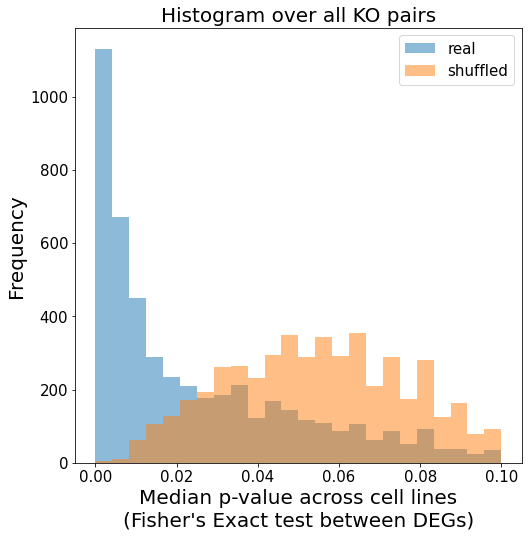

In [34]:
fig,ax = plt.subplots(1, figsize = (8,8))
indices = np.triu_indices(arr['real'].shape[-1], 1)
for name in ['real','shuffled']:
    ax.hist(
        np.min(
            np.median(arr[name],axis = 0),
            axis = 1),
            bins = np.linspace(0,0.1,25),
            alpha = 0.5,
            label = name
            )
ax.tick_params(labelsize = 15)
ax.set_xlabel("Median p-value across cell lines\n(Fisher's Exact test between DEGs)", size = 20)
ax.set_ylabel("Frequency", size = 20)
ax.set_title("Histogram over all KO pairs", size = 20)
ax.legend(prop = {'size':15})


In [36]:
v = {name: [] for name in ['real','shuffled']}
for pthresh in np.logspace(-10,1,100):
    for name in ['real','shuffled']:
        v[name].append(np.sum(np.sum(np.sum(arr[name]<pthresh, axis = 0)>3, axis = 1)>0))

Text(0, 0.5, '# of KOs with at least 1 consistent\n(>3 cell lines) neighbour')

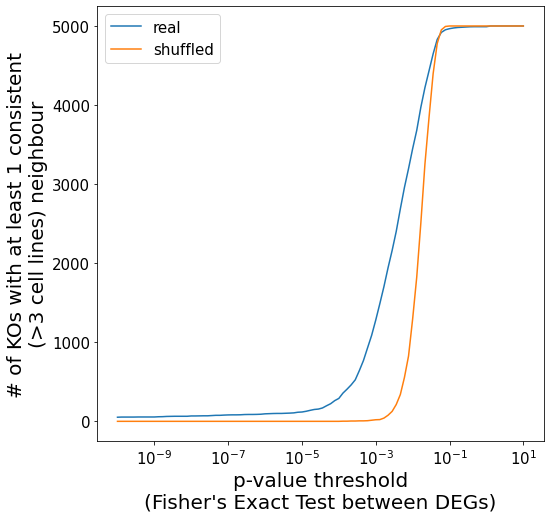

In [38]:
fig, ax = plt.subplots(1, figsize = (8,8))
for name in ['real','shuffled']:
    ax.plot(np.logspace(-10,1,100),v[name], label = name)
ax.set_xscale('log')
ax.legend(prop = {'size':15})
ax.tick_params(labelsize = 15)
ax.set_xlabel("p-value threshold\n(Fisher's Exact Test between DEGs)", size = 20)
ax.set_ylabel("# of KOs with at least 1 consistent\n(>3 cell lines) neighbour", size = 20)